In [8]:
!pip install matplotlib
!pip install tensorflow 

  Using cached tensorflow-2.17.0-cp39-cp39-win_amd64.whl.metadata (3.2 kB)
  Using cached tensorflow_intel-2.17.0-cp39-cp39-win_amd64.whl.metadata (5.0 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-4.25.5-cp39-cp39-win_amd64.whl.metadata (541 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.16.0-cp39-cp39-win_amd64.whl.metadata (6.8 kB)
  Using cached tensorboard-2.17.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.6.0-py3-none-any.whl.metadata (5.8 kB)
  Using cac

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the images (normalize and reshape)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [3]:
def add_noise(images, noise_factor):
    noisy_images = images + noise_factor * np.random.normal(size=images.shape)
    return np.clip(noisy_images, 0., 1.)

# Function to build the conditional autoencoder model
def build_conditional_autoencoder():
    # Define input shape (28x28x1 for grayscale images)
    input_img = Input(shape=(28, 28, 1))

    # Input for the digit label (conditioned input)
    label_input = Input(shape=(10,))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Flatten the image encoding
    x_flattened = Flatten()(x)

    # Combine image encoding and label
    combined = Concatenate()([x_flattened, label_input])

    # Decoder
    x = Dense(7*7*32, activation='relu')(combined)
    x = tf.keras.layers.Reshape((7, 7, 32))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Build the model
    model = Model([input_img, label_input], decoded)
    return model



In [5]:
# Define constants
noise_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
epochs = 50
batch_size = 32
model_filename = 'conditional_autoencoder.keras'

# Function to add noise to the images
def add_noise(images, noise_factor):
    noisy_images = images + noise_factor * np.random.normal(size=images.shape)
    return np.clip(noisy_images, 0., 1.)

# Function to build the conditional autoencoder model
def build_conditional_autoencoder():
    # Define input shape (28x28x1 for grayscale images)
    input_img = Input(shape=(28, 28, 1))

    # Input for the digit label (conditioned input)
    label_input = Input(shape=(10,))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Flatten the image encoding
    x_flattened = Flatten()(x)

    # Combine image encoding and label
    combined = Concatenate()([x_flattened, label_input])

    # Decoder
    x = Dense(7 * 7 * 32, activation='relu')(combined)
    x = tf.keras.layers.Reshape((7, 7, 32))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Build the model
    model = Model([input_img, label_input], decoded)
    return model

# Check if the model is already saved
if os.path.exists(model_filename):
    print("Loading saved model...")
    conditional_autoencoder = load_model(model_filename)

    # Recompile the model after loading
    conditional_autoencoder.compile(optimizer='adam',
                                    loss='binary_crossentropy',
                                    metrics=['mse', 'accuracy'])
    print("Model loaded successfully.")
else:
    print("No saved model found. Building and training a new model...")
    conditional_autoencoder = build_conditional_autoencoder()
    conditional_autoencoder.compile(optimizer='adam',
                                    loss='binary_crossentropy',
                                    metrics=['mse', 'accuracy'])

# Store the training history for each noise level
    histories = {}

    # Assume x_train, y_train, x_test, and y_test are defined
    # Iterate over each noise level
    for noise_level in noise_levels:
        print(f"\nTraining with noise level: {noise_level}")

        # Add noise to the training and testing data
        x_train_noisy = add_noise(x_train, noise_level)
        x_test_noisy = add_noise(x_test, noise_level)

        # Define EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the model
        history = conditional_autoencoder.fit(
            [x_train_noisy, y_train],
            x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=([x_test_noisy, y_test], x_test),
            callbacks=[early_stopping]
        )

        # Store history
        histories[noise_level] = history

        # Plot training and validation loss
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training and Validation Loss (Noise Level: {noise_level})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Save the trained model
    conditional_autoencoder.save(model_filename)
    print(f"Model saved as {model_filename}")

Loading saved model...
Model loaded successfully.
Model saved as conditional_autoencoder.keras


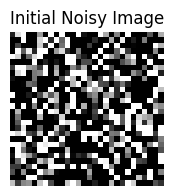

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


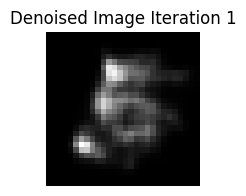

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


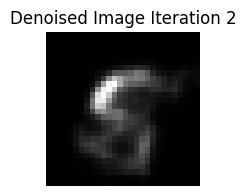

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


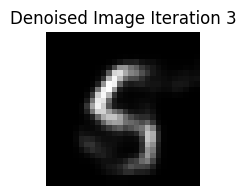

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


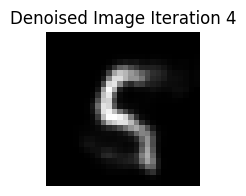

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


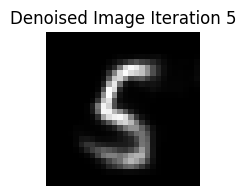

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


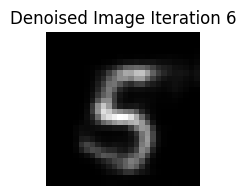

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


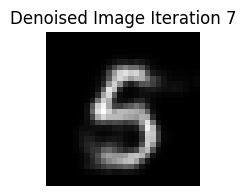

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


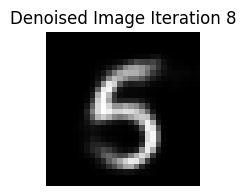

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


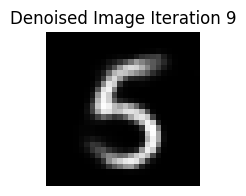

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


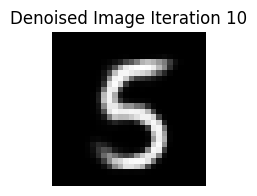

In [14]:
def generate_image_digit(digit, num_iterations=10, noise_level=0.5):

    noise_image = np.random.normal(0, 1, (1, 28, 28, 1))
    noisy_image = np.clip(noise_image + noise_level * np.random.normal(0, 1, noise_image.shape), 0., 1.)
    images_dict = {}  # Dictionary to store denoised images at each iteration

    # Create one-hot encoded label for the digit
    label = to_categorical(digit, num_classes=10).reshape(1, -1)

    # Display the initial noisy image
    plt.figure(figsize=(2, 2))
    plt.imshow(noisy_image[0].reshape(28, 28), cmap='gray')
    plt.title("Initial Noisy Image")
    plt.axis('off')
    plt.show()

    for i in range(num_iterations):
        denoised_image = conditional_autoencoder.predict([noisy_image, label])

        # Store the denoised image in the dictionary
        images_dict[i] = denoised_image[0]  # Store the first (and only) image from the batch

        if i % (num_iterations // 10) == 0:
            # Show the denoised image for the current iteration
            plt.figure(figsize=(2, 2))
            plt.imshow(denoised_image[0].reshape(28, 28), cmap='gray')
            plt.title(f"Denoised Image Iteration {i + 1}")
            plt.axis('off')
            plt.show()

        # Instead of taking the output directly, apply some randomness
        if np.random.rand() < 0.5:  # Randomly decide to add some noise
            denoised_image += noise_level * np.random.normal(size=denoised_image.shape)

        # Prepare for the next iteration
        noisy_image = add_noise(denoised_image, noise_level)

    # Return the dictionary of images
    return images_dict  # Return the dictionary containing all denoised images

img_dict=generate_image_digit(5)


In [ ]:
def generate_image_digit_final(digit, num_iterations=10, noise_level=0.2):
    # Start with a random noise image
    noise_image = np.random.normal(0, 1, (1, 28, 28, 1))
    noisy_image = np.clip(noise_image + noise_level * np.random.normal(0, 1, noise_image.shape), 0., 1.)

    # Create one-hot encoded label for the digit
    label = to_categorical(digit, num_classes=10).reshape(1, -1)

    # Display the initial noisy image
    plt.figure(figsize=(2, 2))
    plt.imshow(noisy_image[0].reshape(28, 28), cmap='gray')
    plt.title("Initial Noisy Image")
    plt.axis('off')
    plt.show()

    for i in range(num_iterations):
        # Denoise the noisy image, providing both image and label as input
        denoised_image = conditional_autoencoder.predict([noisy_image, label])

        # Instead of taking the output directly, apply some randomness
        if np.random.rand() < 0.2 and i<num_iterations:  # Randomly decide to add some noise
            denoised_image += noise_level * np.random.normal(size=denoised_image.shape)

        # Prepare for the next iteration
        noisy_image = add_noise(denoised_image, noise_level)

    # Display the final denoised image
    plt.figure(figsize=(2, 2))
    plt.imshow(denoised_image[0].reshape(28, 28), cmap='gray')
    plt.title(f"Final Denoised Image of Digit {digit}")
    plt.axis('off')
    plt.show()

    return denoised_image[0]  # Return the final denoised image without the array wrapper




Enter a Number you want to generate (0-9) or a negative number to exit: 0


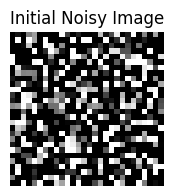

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


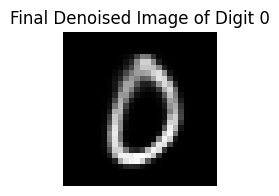

Enter a Number you want to generate (0-9) or a negative number to exit: 6


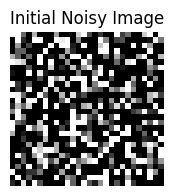

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


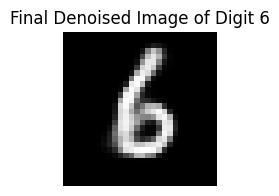

Enter a Number you want to generate (0-9) or a negative number to exit: 8


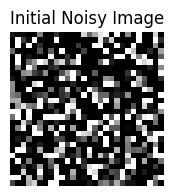

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


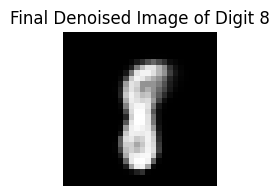

Enter a Number you want to generate (0-9) or a negative number to exit: 8


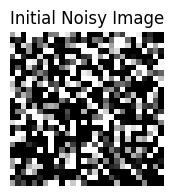

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


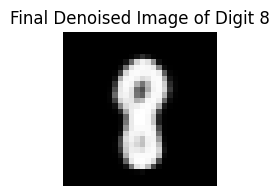

Enter a Number you want to generate (0-9) or a negative number to exit: 8


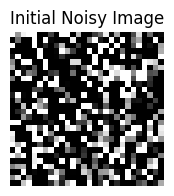

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


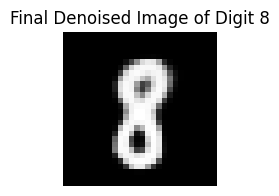

Enter a Number you want to generate (0-9) or a negative number to exit: 6


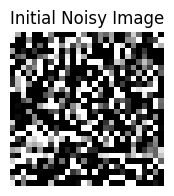

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


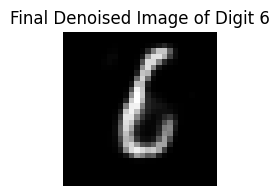

Enter a Number you want to generate (0-9) or a negative number to exit: 9


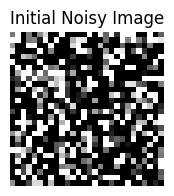

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


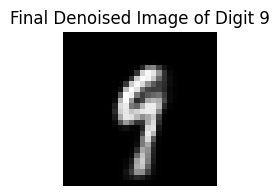

Enter a Number you want to generate (0-9) or a negative number to exit: 9


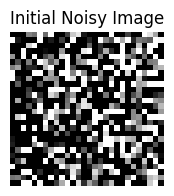

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


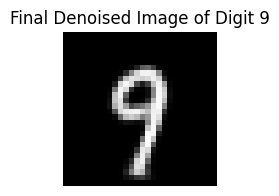

Enter a Number you want to generate (0-9) or a negative number to exit: 7


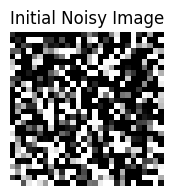

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


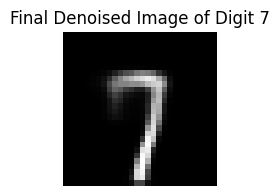

Enter a Number you want to generate (0-9) or a negative number to exit: 7


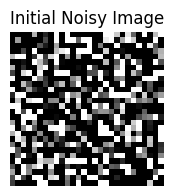

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


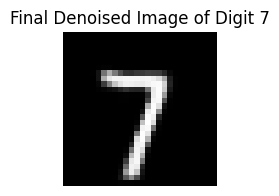

Enter a Number you want to generate (0-9) or a negative number to exit: 7


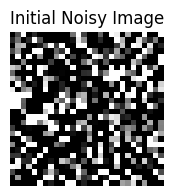

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


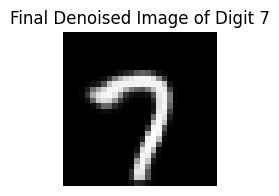

KeyboardInterrupt: Interrupted by user

In [ ]:
while True:
    try:
        x = int(input("Enter a Number you want to generate (0-9) or a negative number to exit: "))

        # Break the loop if a negative number is entered
        if x < 0:
            print("Exiting the input loop.")
            break

        # Validate input range
        if x > 9:
            raise ValueError("The number must be between 0 and 9.")

        final_image = generate_image_digit_final(x, num_iterations=10, noise_level=0.5)

    except ValueError as ve:
        print(f"Input Error: {ve}")
    except Exception as e:
        print(f"An error occurred: {e}")